In [1]:
import pandas as pd
import os

dataframe_cal_housing = pd.read_csv('/home/deepak/CaliforniaHousing/california_housing.csv')

In [2]:
dataframe_cal_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


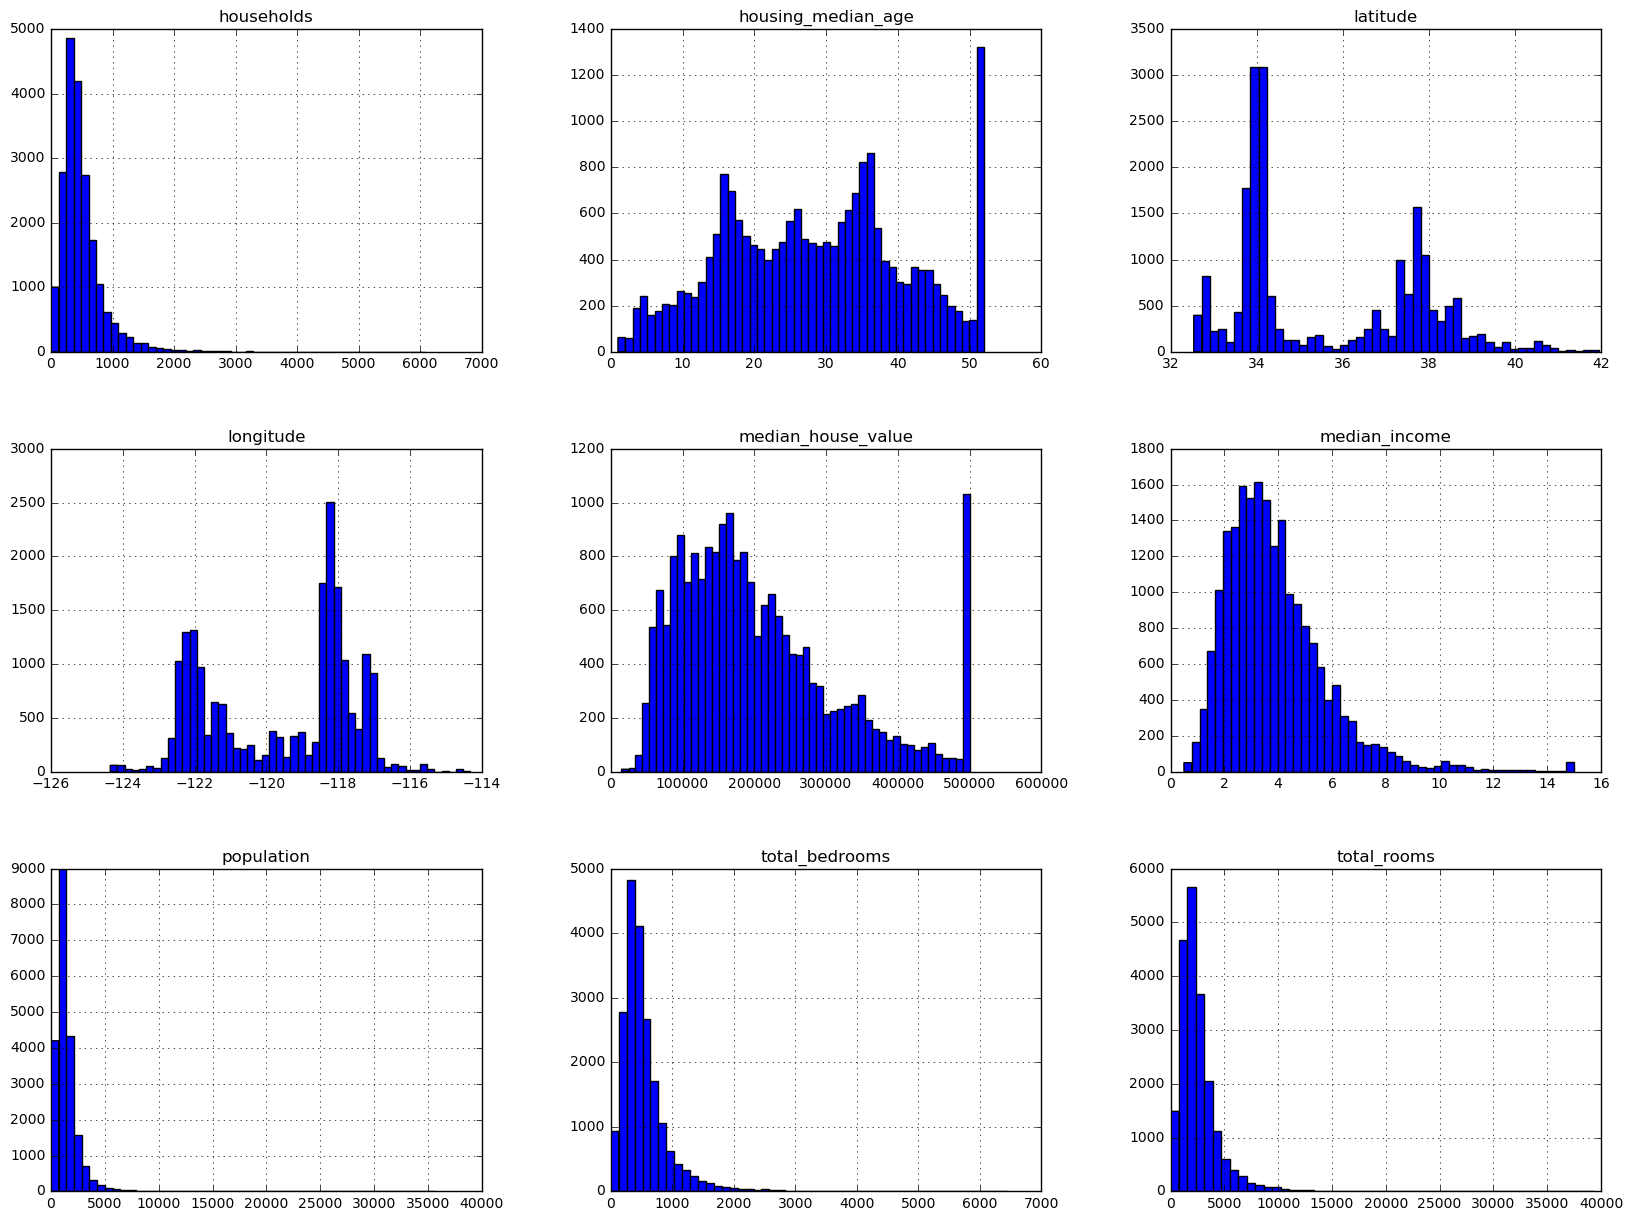

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
dataframe_cal_housing.hist(bins=50,figsize=(20,15))
plt.show()

In [4]:
import numpy as np
def split_train_test_data(data,test_ratio):
    print(len(data))
    shuffled_indices=np.random.permutation(len(data))
    
    test_set_size = int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    training_indices=shuffled_indices[test_set_size:]
    return data.iloc[training_indices],data.iloc[test_indices]

train_set,test_set=split_train_test_data(dataframe_cal_housing,0.2)

len(train_set)

len(test_set)

20640


4128

In [5]:
dataframe_cal_housing['income_cat'] = np.ceil(dataframe_cal_housing['median_income']/1.5)
dataframe_cal_housing['income_cat'].where(dataframe_cal_housing['income_cat'] < 5, 5.0, inplace=True)

import sklearn
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for train_index,test_index in split.split(dataframe_cal_housing,dataframe_cal_housing['income_cat']):
    strat_train_set = dataframe_cal_housing.loc[train_index]
    strat_test_set = dataframe_cal_housing.loc[test_index]

dataframe_cal_housing['income_cat'].value_counts()/len(dataframe_cal_housing)
    

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [6]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [7]:
for data_set in (strat_test_set,strat_train_set,dataframe_cal_housing):
    data_set.drop(['income_cat'],axis=1,inplace=True)

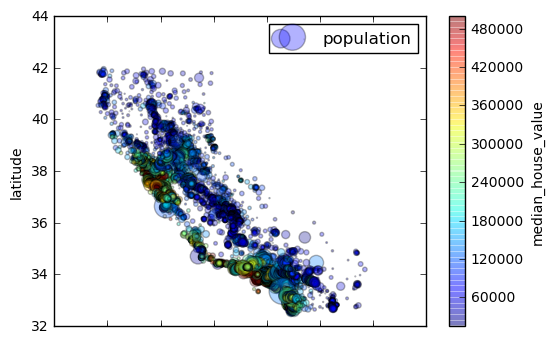

In [8]:
dataframe_cal_housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.3,
                           s=dataframe_cal_housing['population']/100,label='population',
                           c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True
                          
                          )
plt.legend()

In [9]:
corr_matrix = dataframe_cal_housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)




median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94b9247910>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f94cbf0be10>]], dtype=object)

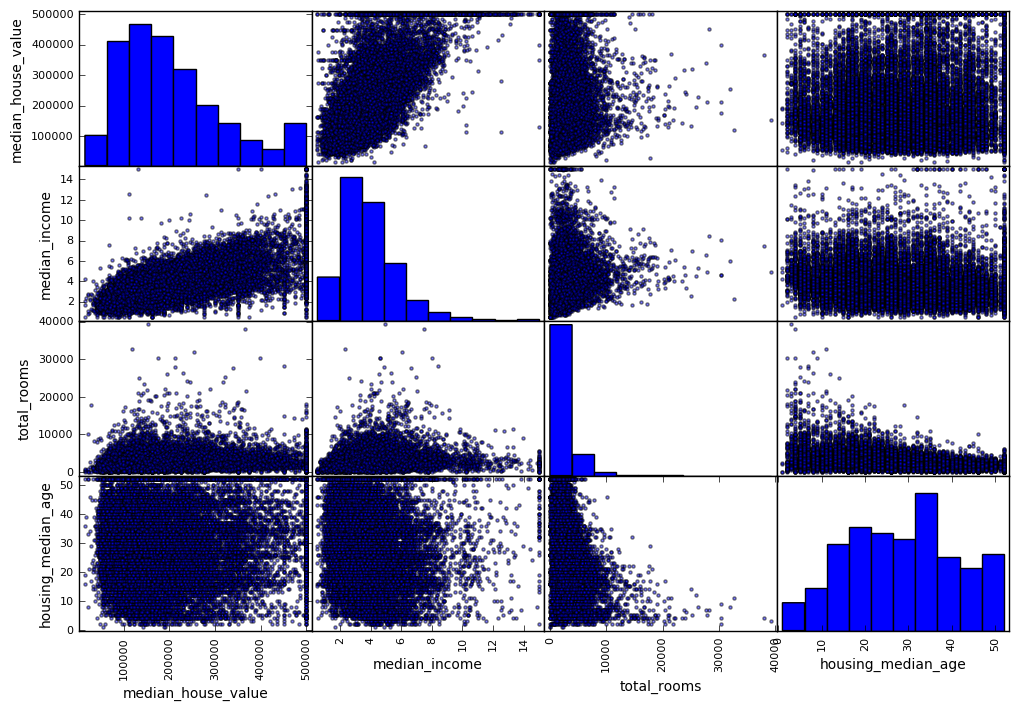

In [10]:
from pandas.tools.plotting import scatter_matrix

attributes=['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(dataframe_cal_housing[attributes],figsize=(12,8))

In [11]:
dataframe_cal_housing['rooms_per_household'] = dataframe_cal_housing['total_rooms']/dataframe_cal_housing['households']


dataframe_cal_housing['bedrooms_by_rooms'] = dataframe_cal_housing['total_bedrooms']/dataframe_cal_housing['total_rooms']


dataframe_cal_housing['population_per_threshold'] = dataframe_cal_housing['population']/dataframe_cal_housing['households']

In [12]:
corr_matrix = dataframe_cal_housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_threshold   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_by_rooms          -0.255880
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94cc157110>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f94cc51f990>]], dtype=object)

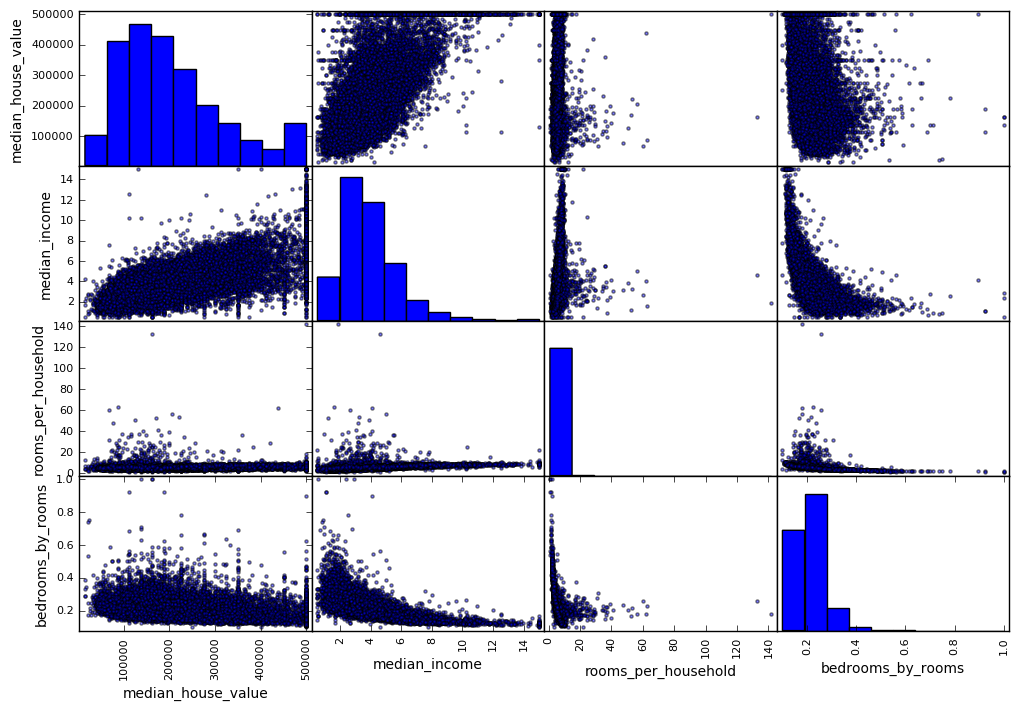

In [13]:
new_attributes = ['median_house_value','median_income','rooms_per_household','bedrooms_by_rooms']

scatter_matrix(dataframe_cal_housing[new_attributes],figsize=(12,8))

In [14]:
%%writefile CustomAttributes.py

import sklearn 
import numpy as np
from sklearn.base import BaseEstimator,TransformerMixin

rooms_ix,bedrooms_ix,population_ix,household_ix = 3,4,5,6

class CustomAttributes(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X,y=None):
        return self # Nothing else to do
    def transform(self,X,y=None):
        rooms_per_household=X[:,rooms_ix]/X[:,household_ix]
        population_per_household=X[:,population_ix]/X[:,household_ix]
        bedrooms_per_room=X[:,bedrooms_ix] / X[:,rooms_ix]
        return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
    

Overwriting CustomAttributes.py


In [15]:
%%writefile DataFrameSelector.py

import sklearn 
import numpy as np
from sklearn.base import BaseEstimator,TransformerMixin


class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,atttibute_names):
        self.atttibute_names = atttibute_names
    def fit(self,X,y=None):
        return self # Nothing else to do
    def transform(self,X,y=None):
        return X[self.atttibute_names].values

Overwriting DataFrameSelector.py


In [16]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [17]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

dataframe_ocean_px_dropped = dataframe_cal_housing.drop('ocean_proximity',axis=1)

imputer.fit(dataframe_ocean_px_dropped)

imputer.statistics_

X=imputer.transform(dataframe_ocean_px_dropped)

housing_tr = pd.DataFrame(X,columns=dataframe_ocean_px_dropped.columns)

In [24]:
test = list(housing)
test.remove('ocean_proximity')
print(test1)

print(test)

None
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [25]:
from sklearn.pipeline import FeatureUnion

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from DataFrameSelector import DataFrameSelector
from CustomAttributes import CustomAttributes

num_attribs=list(housing)

num_attribs.remove('ocean_proximity')

cat_attribs=['ocean_proximity']


num_pipeline = Pipeline([ ('selector',DataFrameSelector(num_attribs)),
                          ('imputer', Imputer()),
                          ('attribs_adder',CustomAttributes()),
                          ('Scaler',StandardScaler())])

cat_pipeline=Pipeline([ ('selector',DataFrameSelector(cat_attribs)),
                        ('label_binarizer', LabelBinarizer())
        
    ])

full_pipeline=FeatureUnion(transformer_list=[ 
        ('num_pipeline',num_pipeline),
        ('cat_pipeline',cat_pipeline)
        
        
    ])


housing_prepared = full_pipeline.fit_transform(housing)



In [35]:
from sklearn.linear_model import LinearRegression 

lin_reg = LinearRegression()

lin_reg.fit(housing_prepared,housing_labels)

    


array([ -55645.98566264,  -56820.80897747,   13720.38285173,
         -4702.9413456 ,   10173.9180045 ,  -45535.38022449,
         45159.77518477,   73897.4931079 ,    6362.30829578,
          1065.56146795,    7161.5964515 ,  -18112.45972402,
        -55939.85071828,  111365.16644656,  -22524.64740512,
        -14788.20859914])

In [39]:
some_Data = housing.iloc[:5]

some_labels=housing_labels[:5]

some_data_prepared=full_pipeline.transform(some_Data)

print("Predictions:\t",lin_reg.predict(some_data_prepared))

print("Labels:\t" , list(some_labels))

from sklearn.metrics import mean_squared_error

lin_mse=mean_squared_error(some_labels,lin_reg.predict(some_data_prepared))

lin_rmse=np.sqrt(lin_mse)


lin_rmse

('Predictions:\t', array([ 210944.00355933,  318525.57377201,  210996.32843857,
         60049.49209858,  191123.83671223]))
('Labels:\t', [286600.0, 340600.0, 196900.0, 46300.0, 254500.0])


46076.899140935959

In [43]:
from sklearn.tree import DecisionTreeRegressor

tree_Reg = DecisionTreeRegressor()

tree_Reg.fit(housing_prepared,housing_labels)


housing_predictions= tree_Reg.transform(housing_prepared)

lin_mse=mean_squared_error(housing_labels,tree_Reg.predict(housing_prepared))

lin_rmse=np.sqrt(lin_mse)


lin_rmse

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


0.0

In [45]:
def display_scores(scores):
    print("Scores:" , scores)
    print("Mean:" , scores.mean())
    print("Standard deviation" , scores.std())
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

forest_reg = RandomForestRegressor()m

# forest_reg.fit(housing_prepared,housing_labels)

reg_scores = cross_val_score(forest_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)

display_scores(reg_scores)

('Scores:', array([ -2.64850592e+09,  -2.51598564e+09,  -2.67194406e+09,
        -2.91320857e+09,  -2.63096285e+09,  -3.22750671e+09,
        -2.65186264e+09,  -2.63307972e+09,  -2.99894863e+09,
        -2.69891092e+09]))
('Mean:', -2759091566.8407431)
('Standard deviation', 206648561.06612888)
